# Projeto florestas aleatórias

LendingClub é uma plataforma de empréstimo financeiro entre pessoas físicas com mais de 3 milhões de membros. Neste projeto apliquei um método de arvores aleatórias para prever se o contratante do empréstimo quitará a sua divida.
https://www.lendingclub.com/

Utilizaremos os dados de empréstimos de 2007-2022 e tentaremos classificar e prever se o mutuário pagou o empréstimo na íntegra. Você pode baixar os dados de [aqui](https://www.lendingclub.com/info/download-data.action) ou apenas usar o csv já fornecido. Recomenda-se que você use o csv fornecido, uma vez que foi limpo dos valores de NA.

Aqui estão o que as colunas representam:

* credit.policy: 1 se o cliente atender aos critérios de subscrição de crédito da LendingClub.com e 0 caso contrário.
* purpose: O objetivo do empréstimo (leva valores "credit_card", "debt_consolidation", "educacional", "grande compra", "small_business" e "all_other").
* int.rate: a taxa de juros do empréstimo (uma taxa de 11% seria armazenada como 0,11). Os mutuários julgados por LendingClub.com para serem mais arriscados recebem taxas de juros mais elevadas.
* installment: as parcelas mensais devidas pelo mutuário se o empréstimo for financiado.
* log.annual.inc: O log natural da renda anual auto-relatada do mutuário.
* dti: Ratio dívida / rendimento do tomador do empréstimo (montante da dívida dividido pela receita anual).
* fico: a pontuação de crédito FICO do mutuário.
* days.with.cr.line: O número de dias em que o mutuário teve uma linha de crédito.
* revol.bal: Saldo rotativo do mutuário (montante não pago no final do ciclo de cobrança do cartão de crédito).
* revol.util: taxa de utilização da linha rotativa do mutuário (o valor da linha de crédito usada em relação ao crédito total disponível).
* inq.last.6mths: número de consultas do mutuário por credores nos últimos 6 meses.
* delinq.2yrs: o número de vezes que o mutuário havia passado mais de 30 dias em um pagamento nos últimos 2 anos.
* pub.rec: O número de registros públicos depreciativos do mutuário (arquivamentos de falências, ônus fiscais ou julgamentos).

<img src='Random-forest-classifier.png'>

# Importar bibliotecas


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Import para teste e validações
from sklearn.metrics import classification_report,confusion_matrix

## Obter dados


In [2]:
loans = pd.read_csv('loan_data.csv')

In [3]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
loans.info()
loans.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

# Análise exploratória de dados 

* histograma de duas distribuições FICO umas sobre as outras, uma para cada um dos valores possíveis de credit.policy


Text(0.5, 0, 'FICO')

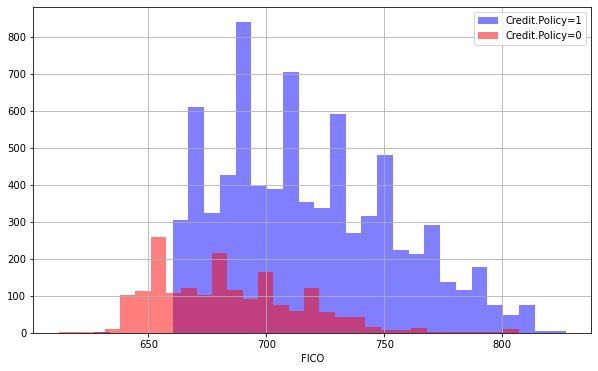

In [5]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')
loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

* Figura semelhante, mas dessa utilizando coluna not.fully.paid.

Text(0.5, 0, 'FICO')

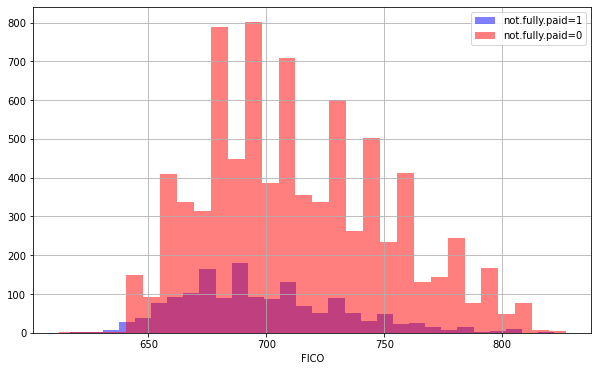

In [6]:
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not.fully.paid=1')
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='not.fully.paid=0')
plt.legend()
plt.xlabel('FICO')

* Contagens de empréstimos por finalidade, com a matiz de cor definido por not.fully.paid.

<AxesSubplot:xlabel='purpose', ylabel='count'>

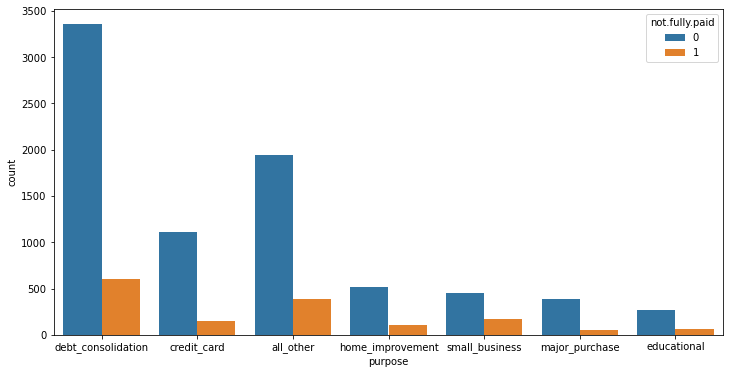

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(x='purpose', hue='not.fully.paid', data=loans)

* Tendência entre o índice FICO e a taxa de juros.

<Figure size 720x720 with 0 Axes>

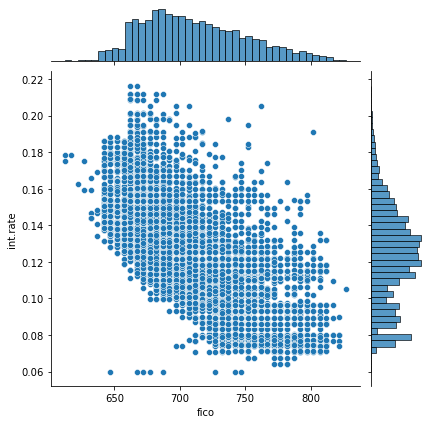

In [8]:
plt.figure(figsize=(10,10))
sns.jointplot(x='fico', y='int.rate', data=loans)

* Tendência diferiu entre not.fully.paid e credit.policy.

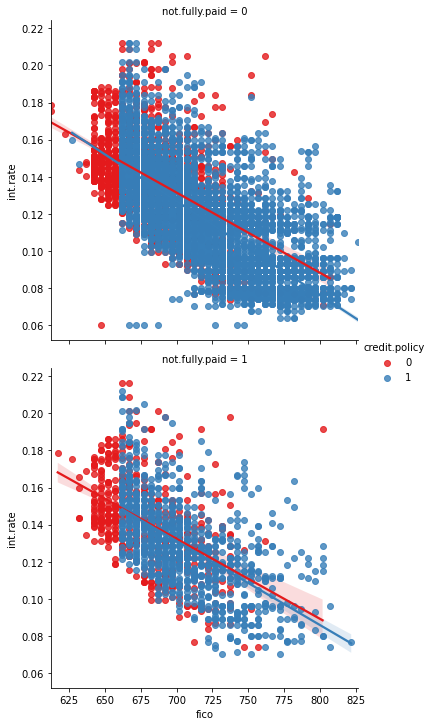

In [9]:
sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',
           col='not.fully.paid',palette='Set1', col_wrap=1)

<Figure size 1080x360 with 0 Axes>

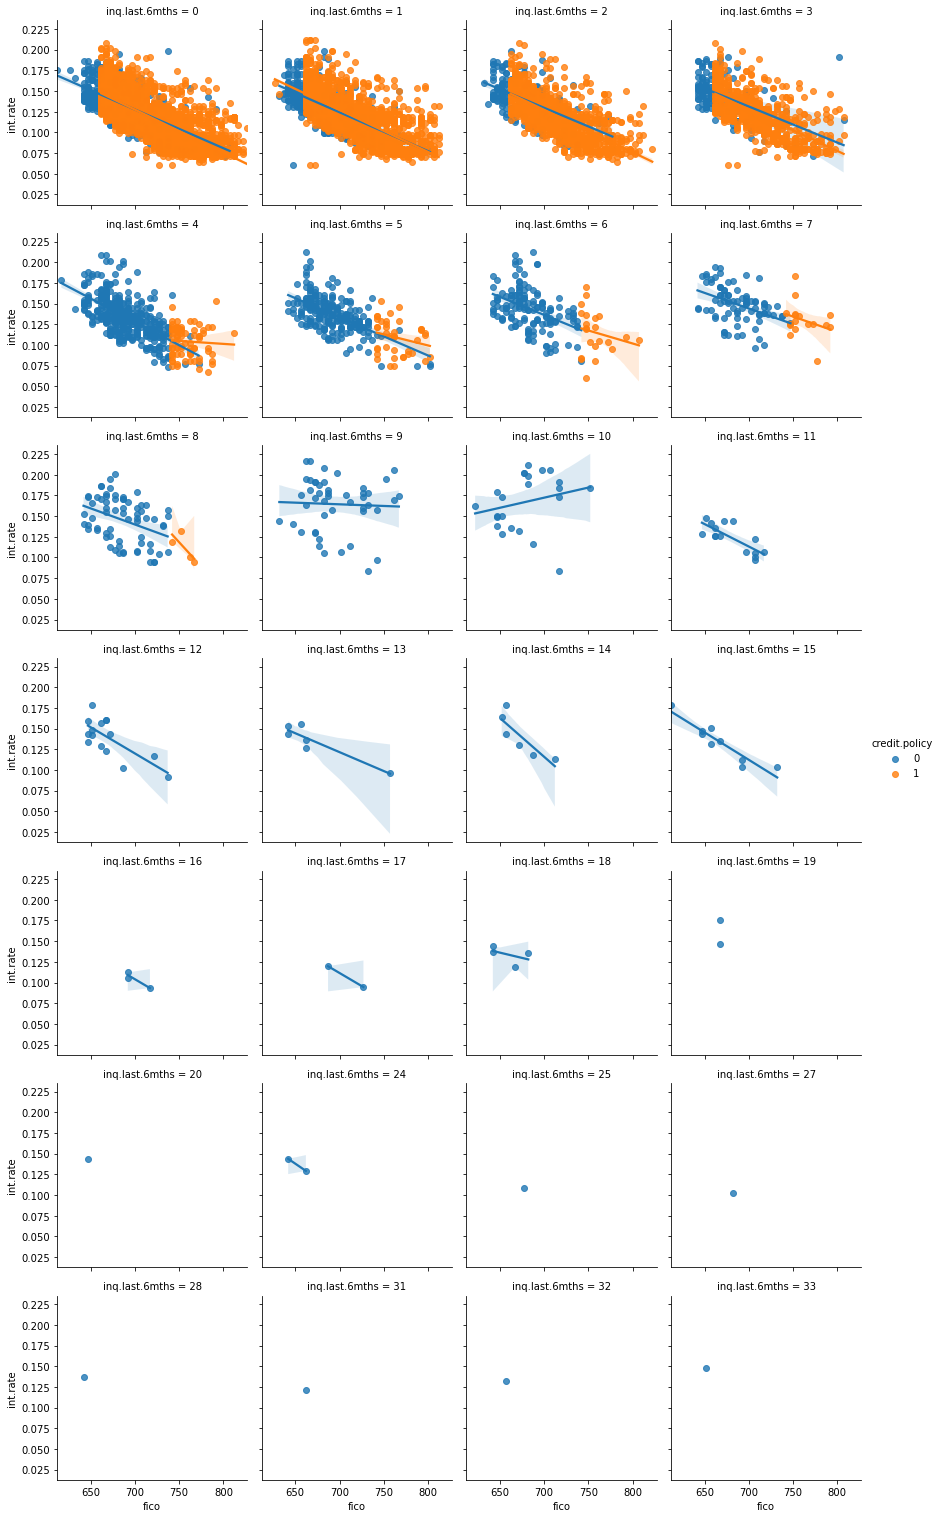

In [10]:

plt.figure(figsize=(15, 5))
sns.lmplot(y="int.rate", x="fico", data=loans, hue='credit.policy', col='inq.last.6mths',col_wrap=4, height=3)

# Configurando os dados

Configurando os dados para o modelo de classificação de florestas aleatórias!


## Recursos categóricos

### Trabalhando com variaveis dummies

* A coluna "purpose" possui dados categórica.

Isso significa que precisamos transformá-los usando variáveis dummys para que Sklearn possa compreendê-las. Vamos fazer isso em um passo limpo usando pd.get_dummies.

In [11]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [12]:
loans['purpose'].head()

0    debt_consolidation
1           credit_card
2    debt_consolidation
3    debt_consolidation
4           credit_card
Name: purpose, dtype: object

In [13]:
cat_feats = ['purpose']

* Usanremos o cod "pd.get_dummies(loans, columns = cat_feats, drop_first = True)" para criar um DataFrame maior fixo que tenha novas colunas de recursos com variáveis dummy. Chame este dataframe de final_data.

In [14]:
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)

In [15]:
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


## Divisão Treino-Teste de dados

In [34]:
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Training a Decision Tree Model

* Treinando uma única árvore de decisão primeiro!

* Criação da instância de DecisionTreeClassifier() chamada dtree e fite-a com os dados de treinamento.

In [36]:
dtree = DecisionTreeClassifier()

In [37]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

# Treino 1 - Previsões e avaliação da árvore de decisão


* Utilizando o predictions

In [43]:
predictions = dtree.predict(X_test)

In [44]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2431
           1       0.20      0.24      0.22       443

    accuracy                           0.73      2874
   macro avg       0.53      0.53      0.53      2874
weighted avg       0.75      0.73      0.74      2874



In [45]:
print(confusion_matrix(y_test,predictions))

[[1997  434]
 [ 336  107]]


# Treino 2 - Treinando o modelo de florestas aleatórias



* Criando a  instância da classe RandomForestClassifier e ajuste-a aos nossos dados de treinamento da etapa anterior.

In [27]:
rfc = RandomForestClassifier(n_estimators=600)

In [47]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

## Previsões e Avaliação

* Prevendo os valores do y_test e avaliar o nosso modelo.


In [48]:
predictions1 = rfc.predict(X_test)

relatório de classificação dos resultados.

In [49]:
print(classification_report(y_test,predictions1))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.53      0.02      0.03       443

    accuracy                           0.85      2874
   macro avg       0.69      0.51      0.48      2874
weighted avg       0.80      0.85      0.78      2874



* Matriz de Confusão para as previsões.

In [50]:
print('Matris com arvore aleatoria')
print(confusion_matrix(y_test,predictions1))
print()
print('Matris com arvore padrão')
print(confusion_matrix(y_test,predictions))

Matris com arvore aleatoria
[[2424    7]
 [ 435    8]]

Matris com arvore padrão
[[1997  434]
 [ 336  107]]


** O que performou melhor: a floresta aleatória ou a árvore de decisão? **

### Depende da métrica para a qual você está tentando otimizar.
### Observe o recall para cada classe para os modelos.

### Nenhum dos dois performou muito bem. Mais engenharia nos dados seria necessária para que talvez conseguissemos algum resultado superior.